In [17]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
import jobs

# standardize plot
def standardize(size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(300)
  # set font
  plt.rcParams.update({'font.size': 12})

# smoothening function
def smooth(vals):
  window_size = 50
  kernel = np.ones(window_size) / window_size
  return np.convolve(vals, kernel, mode='same')

### Single time-instance problem analysis for different parameter choices

In [18]:
def read_data(dirname):
  # get all files with .pkl extension
  files = [f for f in os.listdir(dirname) if f.endswith('.pkl')]
  data = {}
  for filename in files:
    with open(os.path.join(dirname, filename), 'rb') as f:
      fdata = pickle.load(f)
    beta, mu = fdata["beta"], fdata["prox_mu"]
    print(f"Beta: {beta}, mu: {mu}")
    data[(beta, mu)] = fdata
  return data

dirname = "/home/sauce/data/solvers/logs/pjadmm_param_sweep/10kgpu"
data = read_data(dirname)

Beta: 1.0, mu: 0.10000000149011612
Beta: 1.0, mu: 100.0
Beta: 0.10000000149011612, mu: 1.0
Beta: 10.0, mu: 0.10000000149011612
Beta: 10.0, mu: 100.0
Beta: 0.10000000149011612, mu: 10.0
Beta: 1.0, mu: 1.0
Beta: 0.10000000149011612, mu: 100.0
Beta: 10.0, mu: 10.0
Beta: 1.0, mu: 10.0
Beta: 0.10000000149011612, mu: 0.10000000149011612
Beta: 10.0, mu: 1.0


Text(0.5, 0, 'Iteration')

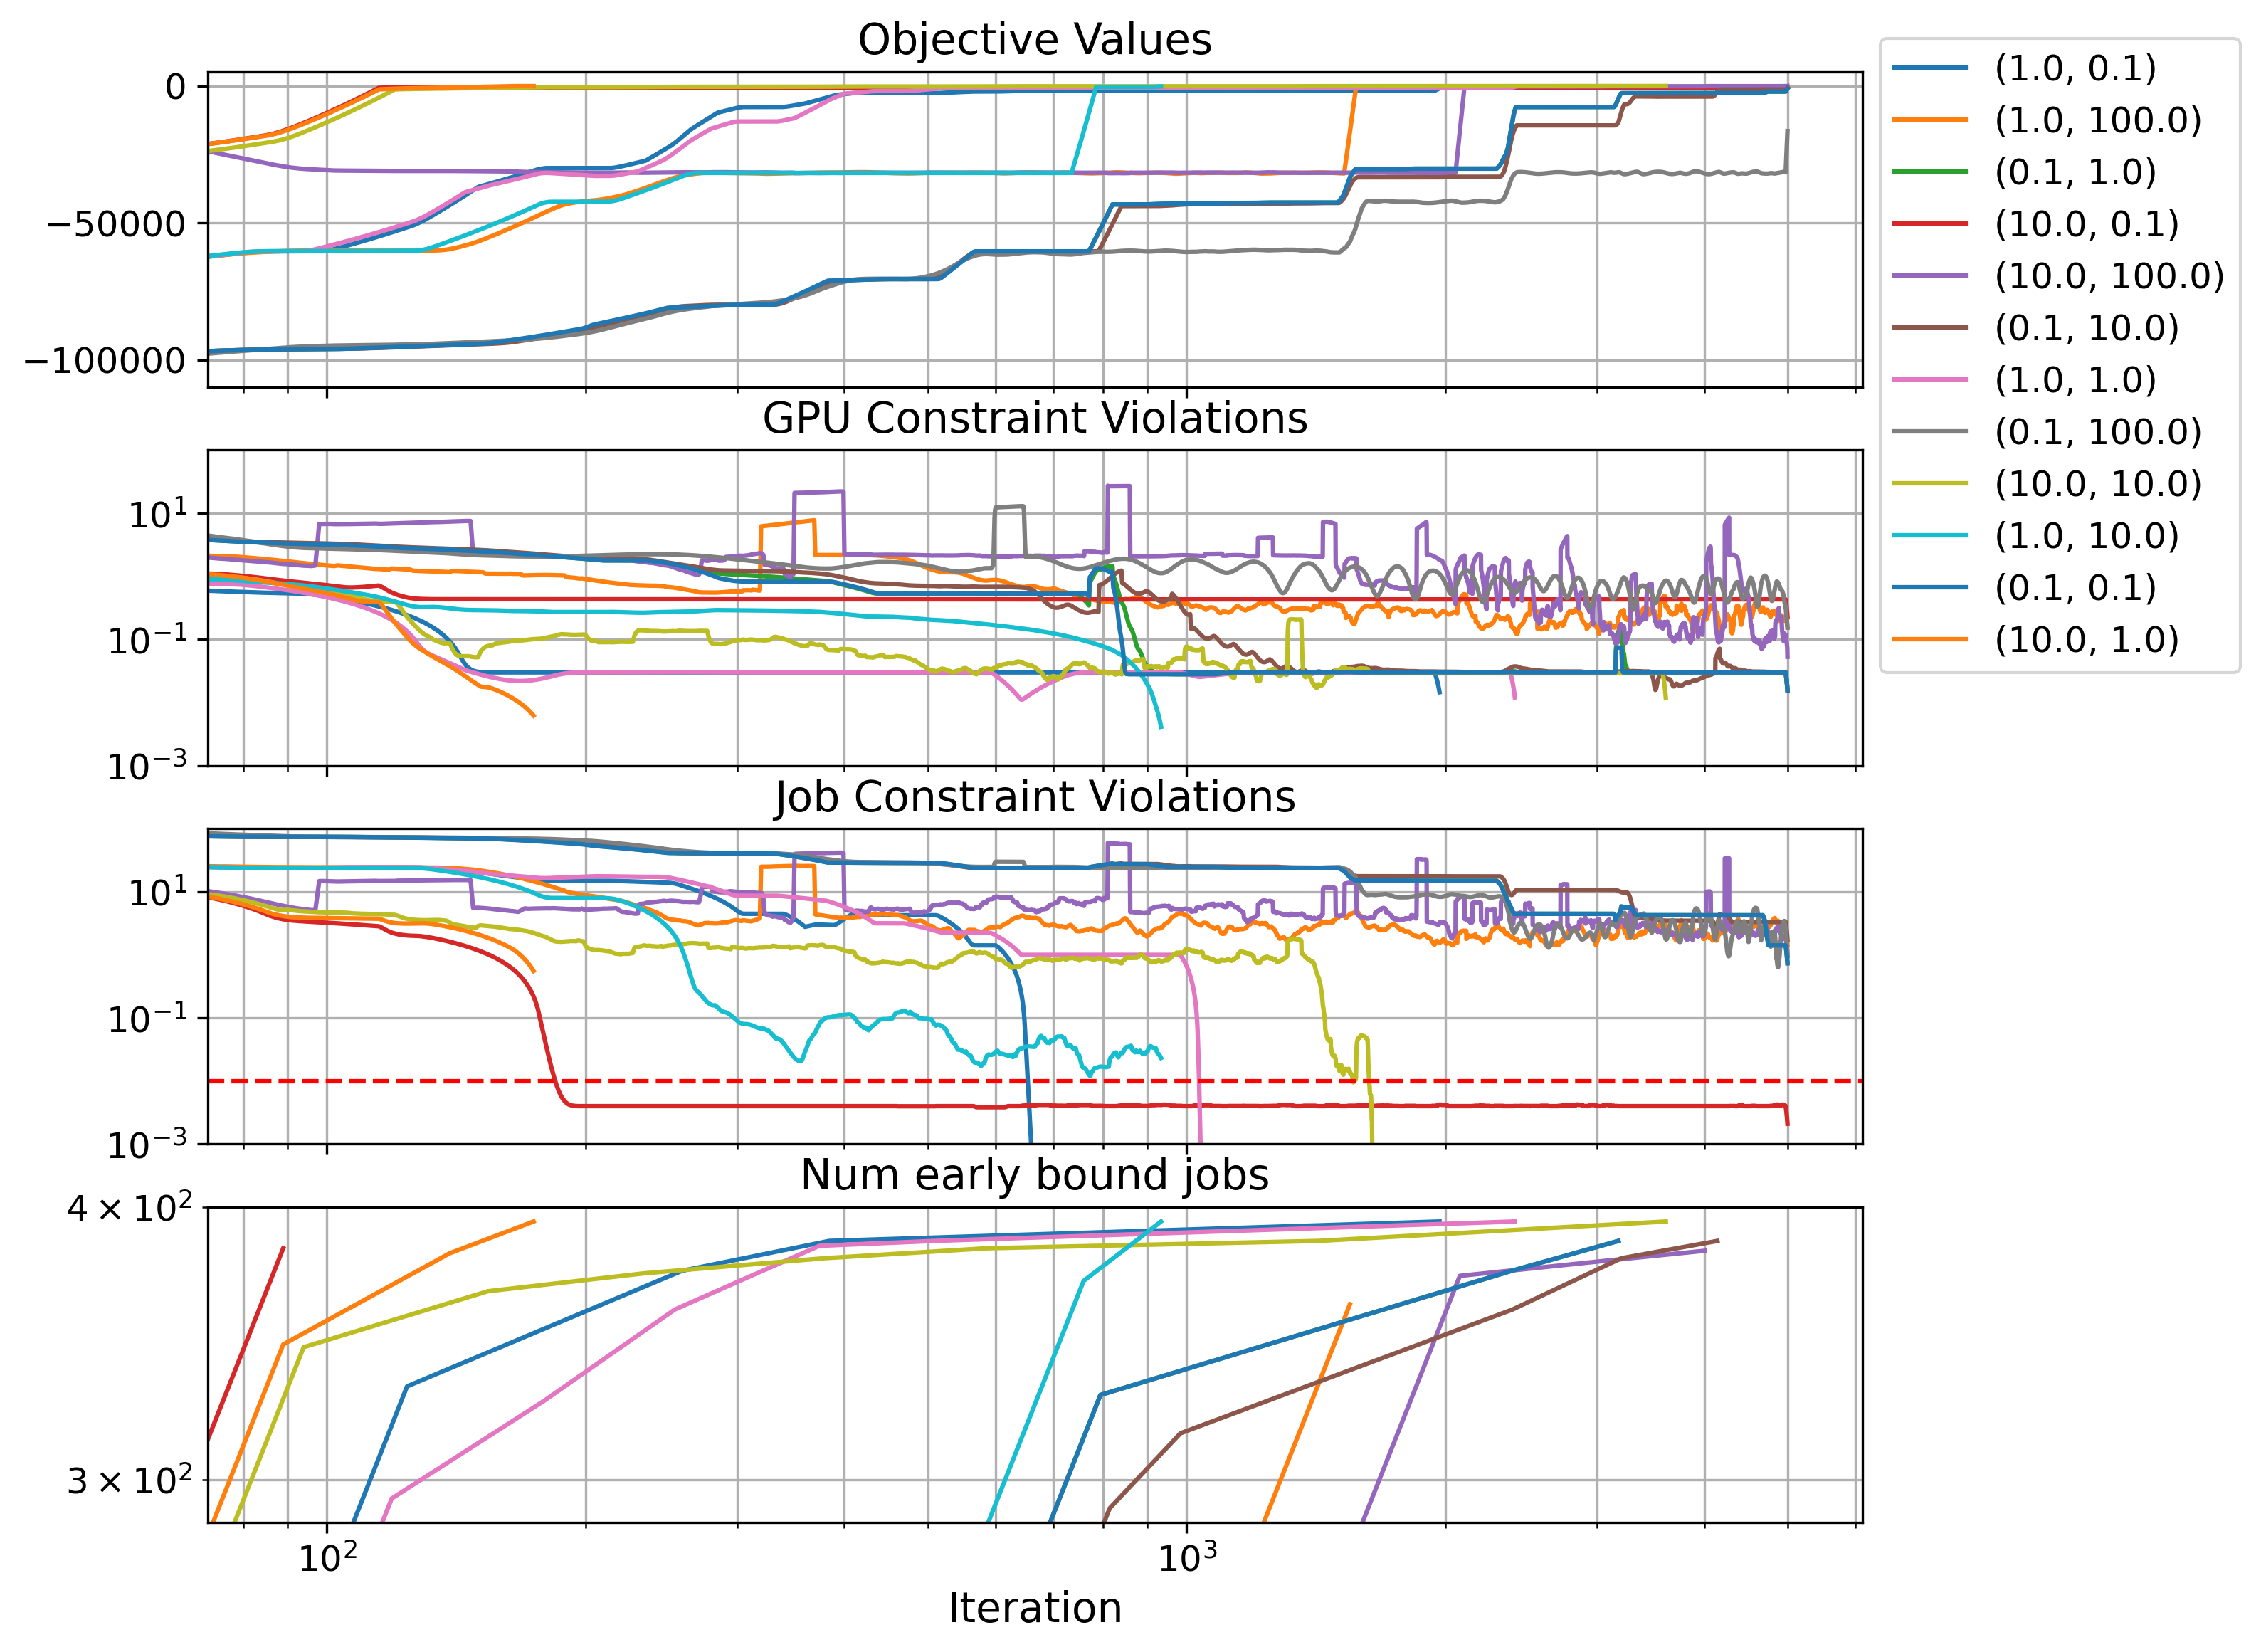

In [19]:
# create a 4x1 plot
fig, axs = plt.subplots(4, 1, sharex=True)
# standardize the plot
standardize(size=(10, 9))
# first plot objective values for each (beta, mu) pair in data
axs[0].set_title("Objective Values")
axs[0].grid(True, which='both')
# second plot GPU constraint violations
axs[1].set_title("GPU Constraint Violations")
axs[1].grid(True, which='both')
# third plot job constraint violation
axs[2].set_title("Job Constraint Violations")
axs[2].grid(True, which='both')
# fourth plot early bound jobs
axs[3].set_title("Num early bound jobs")
axs[3].grid(True, which='both')

for k, v in data.items():
  beta, mu = k
  # get the objective values
  obj = v["obj_vals"]
  # plot the objective values
  axs[0].plot(smooth(obj), label=f"({np.round(beta, 1)}, {np.round(mu, 1)})")
  # get the GPU constraint violations
  gpu = v["gpu_cnstr_viol_norms"]
  # plot the GPU constraint violations
  axs[1].plot(smooth(gpu))
  # get the job constraint violations
  job = v["sumto1_cnstr_viol_norms"]
  # plot the job constraint violations
  axs[2].plot(smooth(job))
  # early bindings
  early_bound = v["early_bound"]
  xs = [x[1] for x in early_bound]
  ys = [x[0] for x in early_bound]
  axs[3].plot(xs, ys)
# add legend in the first plot
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.1))
# set ylims
axs[1].set_ylim(1e-3, 100)
axs[1].set_yscale("log")
axs[2].set_ylim(1e-3, 100)
axs[2].set_yscale("log")
axs[2].axhline(1e-2, color='r', linestyle='--')
# axs[3].set_ylim(1, 1000)
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel("Iteration", fontsize=14)

### Warm-started analsis for different parameter choices

In [107]:
def read_data_warm_started(dirname, filter_str):
  # get all files with .pkl extension
  files = [f for f in os.listdir(dirname) if f.endswith('.pkl') and filter_str in f]
  data = {}
  for filename in files:
    with open(os.path.join(dirname, filename), 'rb') as f:
      fdata = pickle.load(f)
    track_stats = fdata['solver_stats'][0]['track_stats']
    beta, mu = track_stats["beta"], track_stats["prox_mu"]
    print(f"Beta: {beta}, mu: {mu}")
    single_data = []
    for x in fdata['solver_stats']:
      add_dict = x['track_stats']
      new_x = x
      new_x.pop('track_stats')
      new_x.update(add_dict)
      single_data.append(new_x)
    data[(beta, mu)] = single_data
  return data

dirname = "/home/sauce/data/solvers/logs/pjadmm_warm_start_param_sweep"


In [121]:
# get data for 10s
data_10s = read_data_warm_started(dirname, "8x_10s")
# get data for 15s
data_15s = read_data_warm_started(dirname, "8x_15s")
# get data for 30s
data_30s = read_data_warm_started(dirname, "8x_30s")
# get data for 16x 10s
data_16x_10s = read_data_warm_started(dirname, "16x_10s")

Beta: 0.1, mu: 0.1
Beta: 1.0, mu: 0.01
Beta: 0.1, mu: 0.01
Beta: 1.0, mu: 0.1
Beta: 0.1, mu: 0.1
Beta: 10.0, mu: 0.01
Beta: 1.0, mu: 0.1
Beta: 0.1, mu: 0.01
Beta: 1.0, mu: 0.01
Beta: 0.1, mu: 0.01
Beta: 0.1, mu: 0.1
Beta: 1.0, mu: 1.0
Beta: 1.0, mu: 0.1
Beta: 0.2, mu: 0.01
Beta: 0.1, mu: 0.01
Beta: 0.05, mu: 0.001


In [122]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
def plot_warm_start_progress(vals, interval, prefix_str):
  # keys: ['binarization', 'gpu_cnstr_viol_norms', 'obj_vals', 'sumto1_cnstr_viol_norms', 'beta', 
  #        'prox_mu', 'dual_tau', 'num_jobs', 'num_configs', 'num_blocks', 'early_bound']
  # create a 4x1 plot
  num_plots = 5
  fig, axs = plt.subplots(num_plots, 1, sharex=True)
  for i in range(num_plots):
    axs[i].grid(False)
  # standardize the plot
  standardize(size=(10, 2.5*num_plots))
  #### First plot num jobs for each (beta, mu) pair in data
  axs[0].set_title("Num Jobs")
  # get the num jobs
  num_jobs = {k : [] for k in vals.keys()}
  for k, val in vals.items():
    for v in val:
      num_jobs[k].append(v['num_jobs'])
  num_vals = len(list(num_jobs.values())[0])
  xs = np.arange(0, num_vals * interval, interval)
  # plot the num jobs
  for k, v in num_jobs.items():
    axs[0].plot(xs[:len(v)], v, label=f"{k}")
  
  def plot_call_points(min_x, max_x, interval, ax):
    for i in range(min_x, max_x, interval):
      ax.axvline(i, color='k', linestyle='-', alpha=0.5, linewidth=0.3)
  for i in range(num_plots):
    plot_call_points(0, interval * num_vals, interval, axs[i])

  #### Second plot num iters for each (beta, mu) pair in data
  axs[1].set_title("Num iters (Proximal Jacobi ADMM)")
  # get num iters  each key for each time
  num_iters = {k : [] for k in vals.keys()}
  for k, val in vals.items():
    for v in val:
      num_iters[k].append(len(v['obj_vals']))
  # plot num iters 
  for k, v in num_iters.items():
    axs[1].plot(xs[:len(v)], v, label=f"{k}")
  # add legend in the first plot
  axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.1))
  axs[1].axhline(5000, color='r', linestyle='--')
  axs[1].set_yscale("log")

  ### Third plot runtimes for each (beta, mu) pair in data
  axs[2].set_title("Solver runtime (target <= 20 seconds)")
  # get the runtimes
  runtimes = {k : [] for k in vals.keys()}
  for k, val in vals.items():
    for v in val:
      runtimes[k].append(v['solve_time_ms'] / 1000)
  # plot the runtimes
  for k, v in runtimes.items():
    axs[2].plot(xs[:len(v)], v, label=f"{k}")
  # axs[2].set_yscale("log")
  axs[2].axhline(20, color='r', linestyle='--')

  ### Fourth plot GPU Constraint violation for each (beta, mu) pair in data
  axs[3].set_title("Final GPU cnstr violation")
  # get the constraint violations
  gpu_cnstr_viol = {k : [] for k in vals.keys()}
  for k, val in vals.items():
    for v in val:
      gpu_cnstr_viol[k].append(v['gpu_cnstr_viol_norms'][-1])
  # plot the constraint violations
  for k, v in gpu_cnstr_viol.items():
    axs[3].plot(xs[:len(v)], v, label=f"{k}")
  axs[3].set_yscale("log")
  axs[3].set_ylim(1e-3, 100)
  axs[3].axhline(1e-2, color='r', linestyle='--')

  ### Fifth plot sumto1 constraint violations
  axs[4].set_title("Final Job cnstr violation")
  # get the constraint violations
  job_cnstr_viol = {k : [] for k in vals.keys()}
  for k, val in vals.items():
    for v in val:
      job_cnstr_viol[k].append(v['sumto1_cnstr_viol_norms'][-1])
  # plot the constraint violations
  for k, v in job_cnstr_viol.items():
    axs[4].plot(xs[:len(v)], v, label=f"{k}")
  axs[4].set_yscale("log")
  axs[4].set_ylim(1e-3, 100)
  axs[4].axhline(1e-2, color='r', linestyle='--')
  axs[4].set_xlim(0, interval * num_vals+1)
  axs[4].set_xlabel("Simulator time (s)", fontsize=14)
  plt.savefig(f"/tmp/{prefix_str}_warm_start_{interval}s.png", bbox_inches='tight', dpi=300)


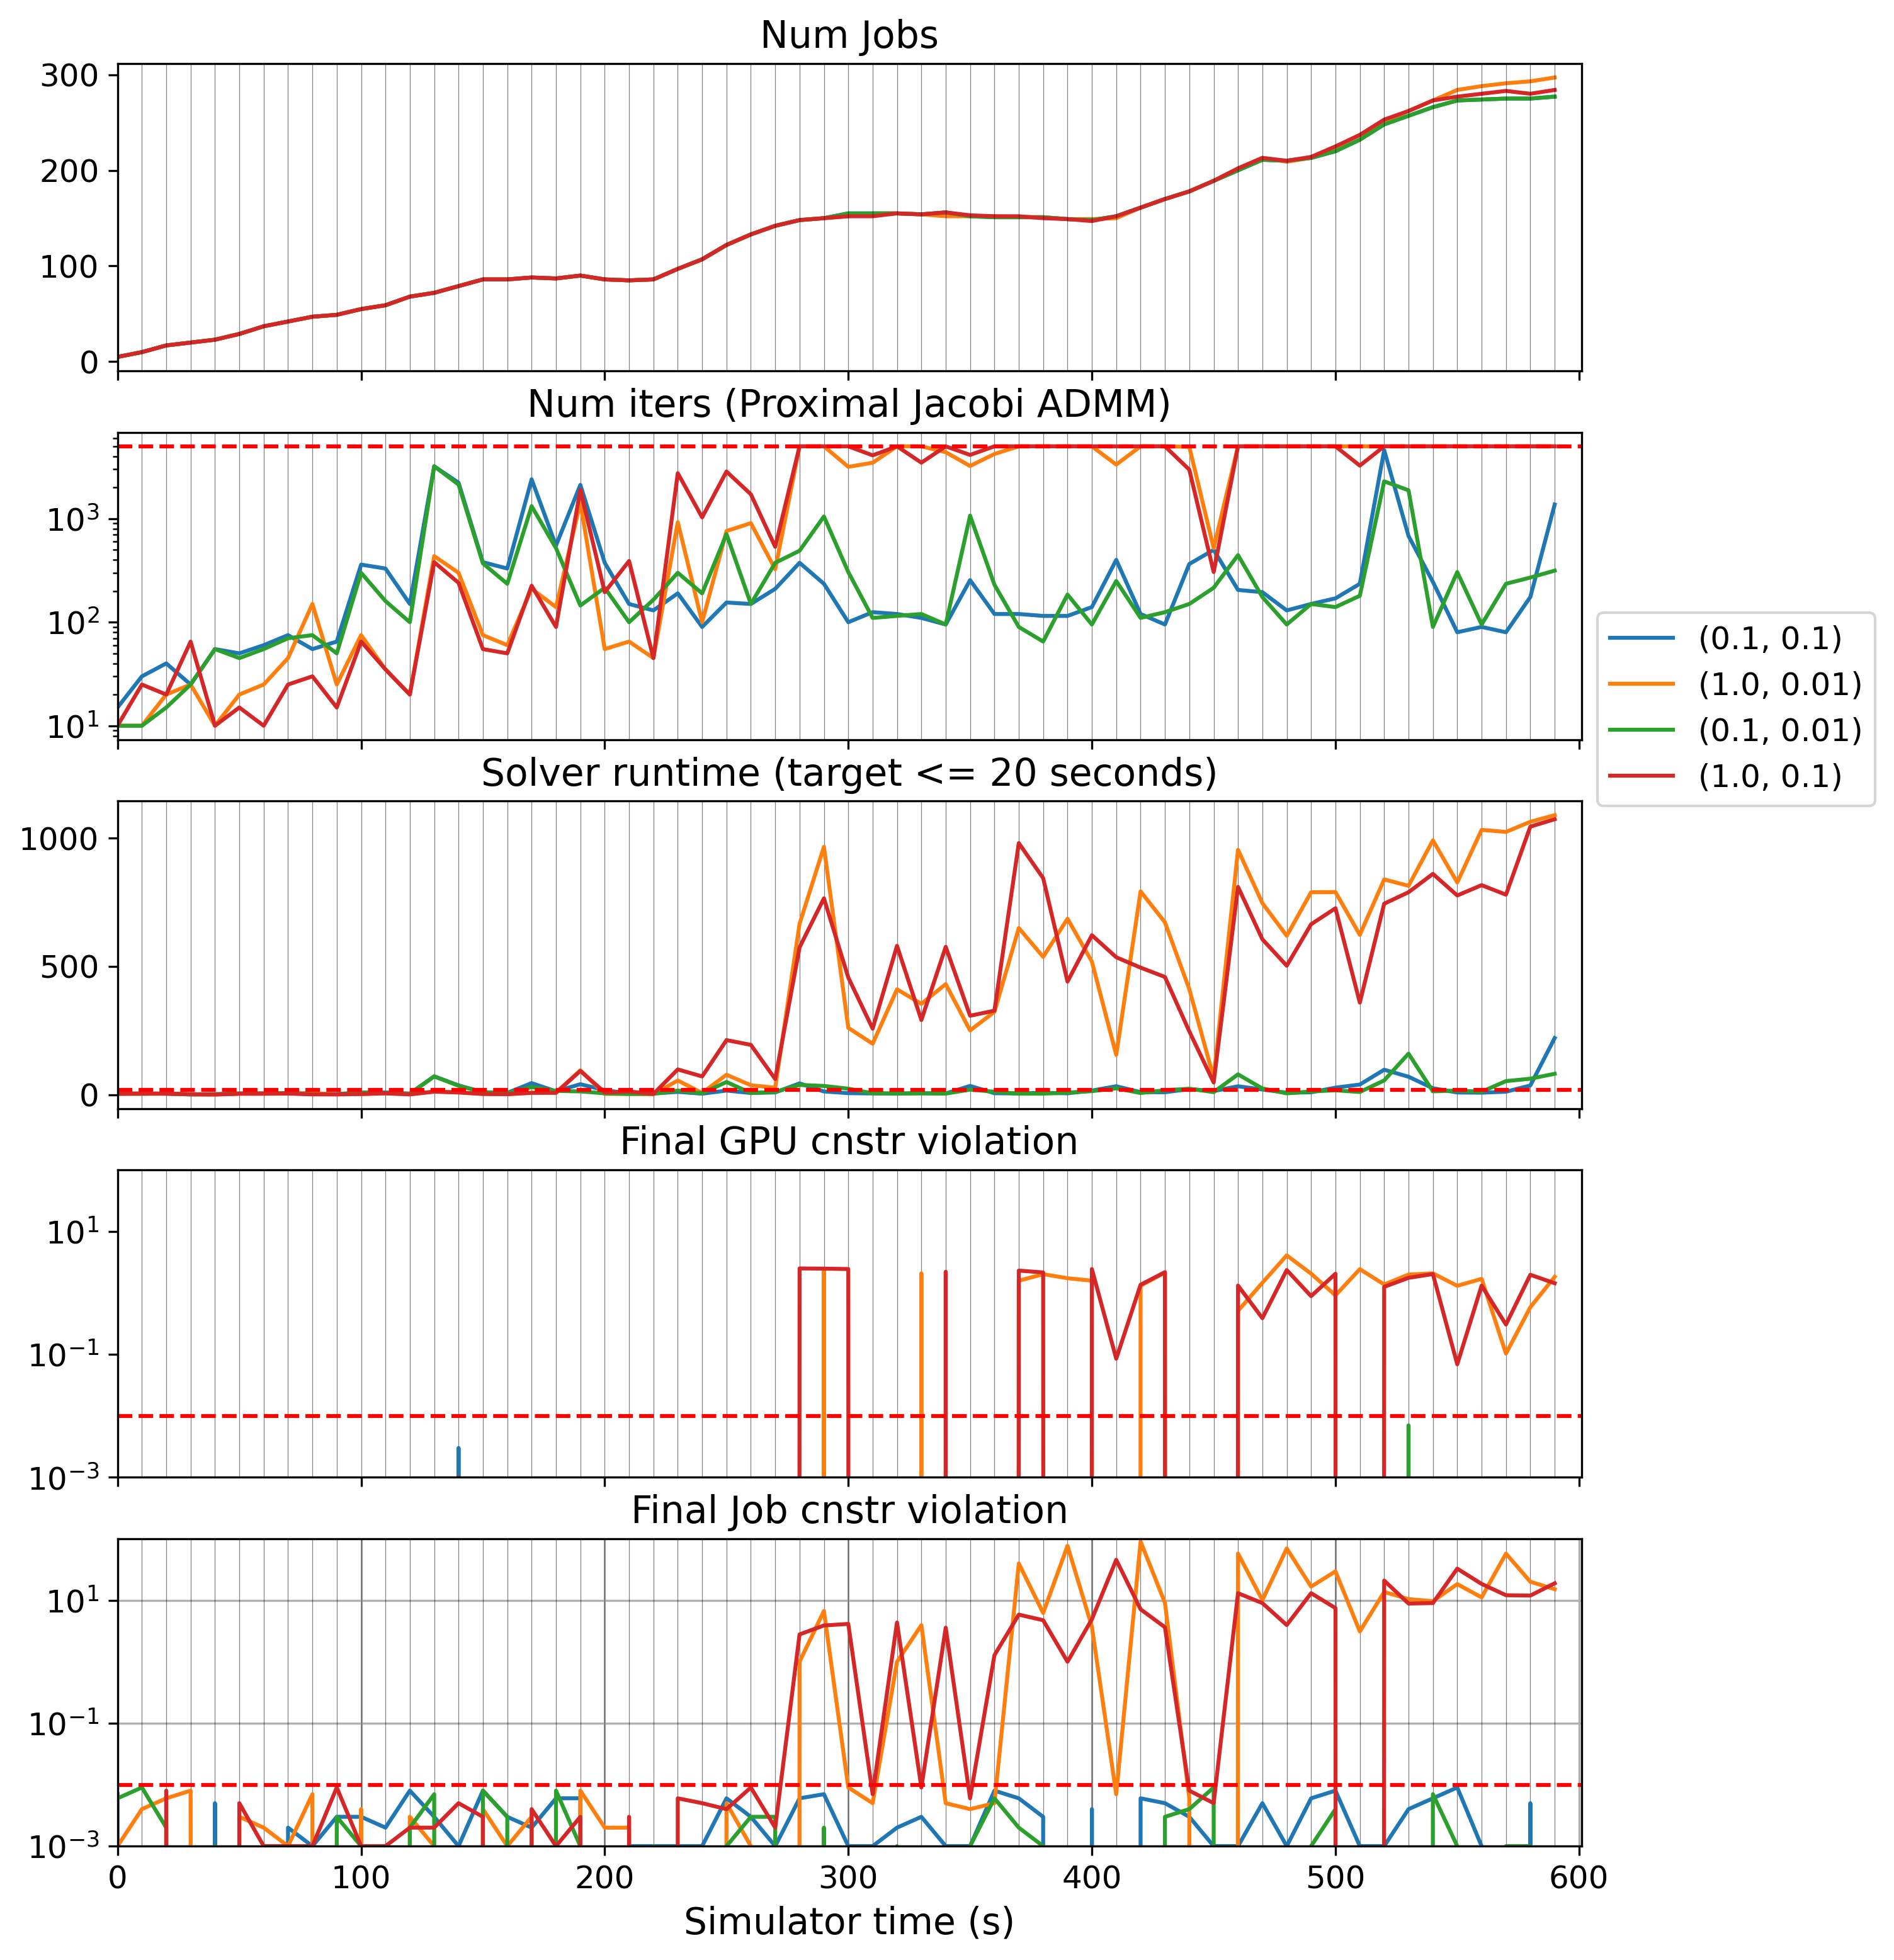

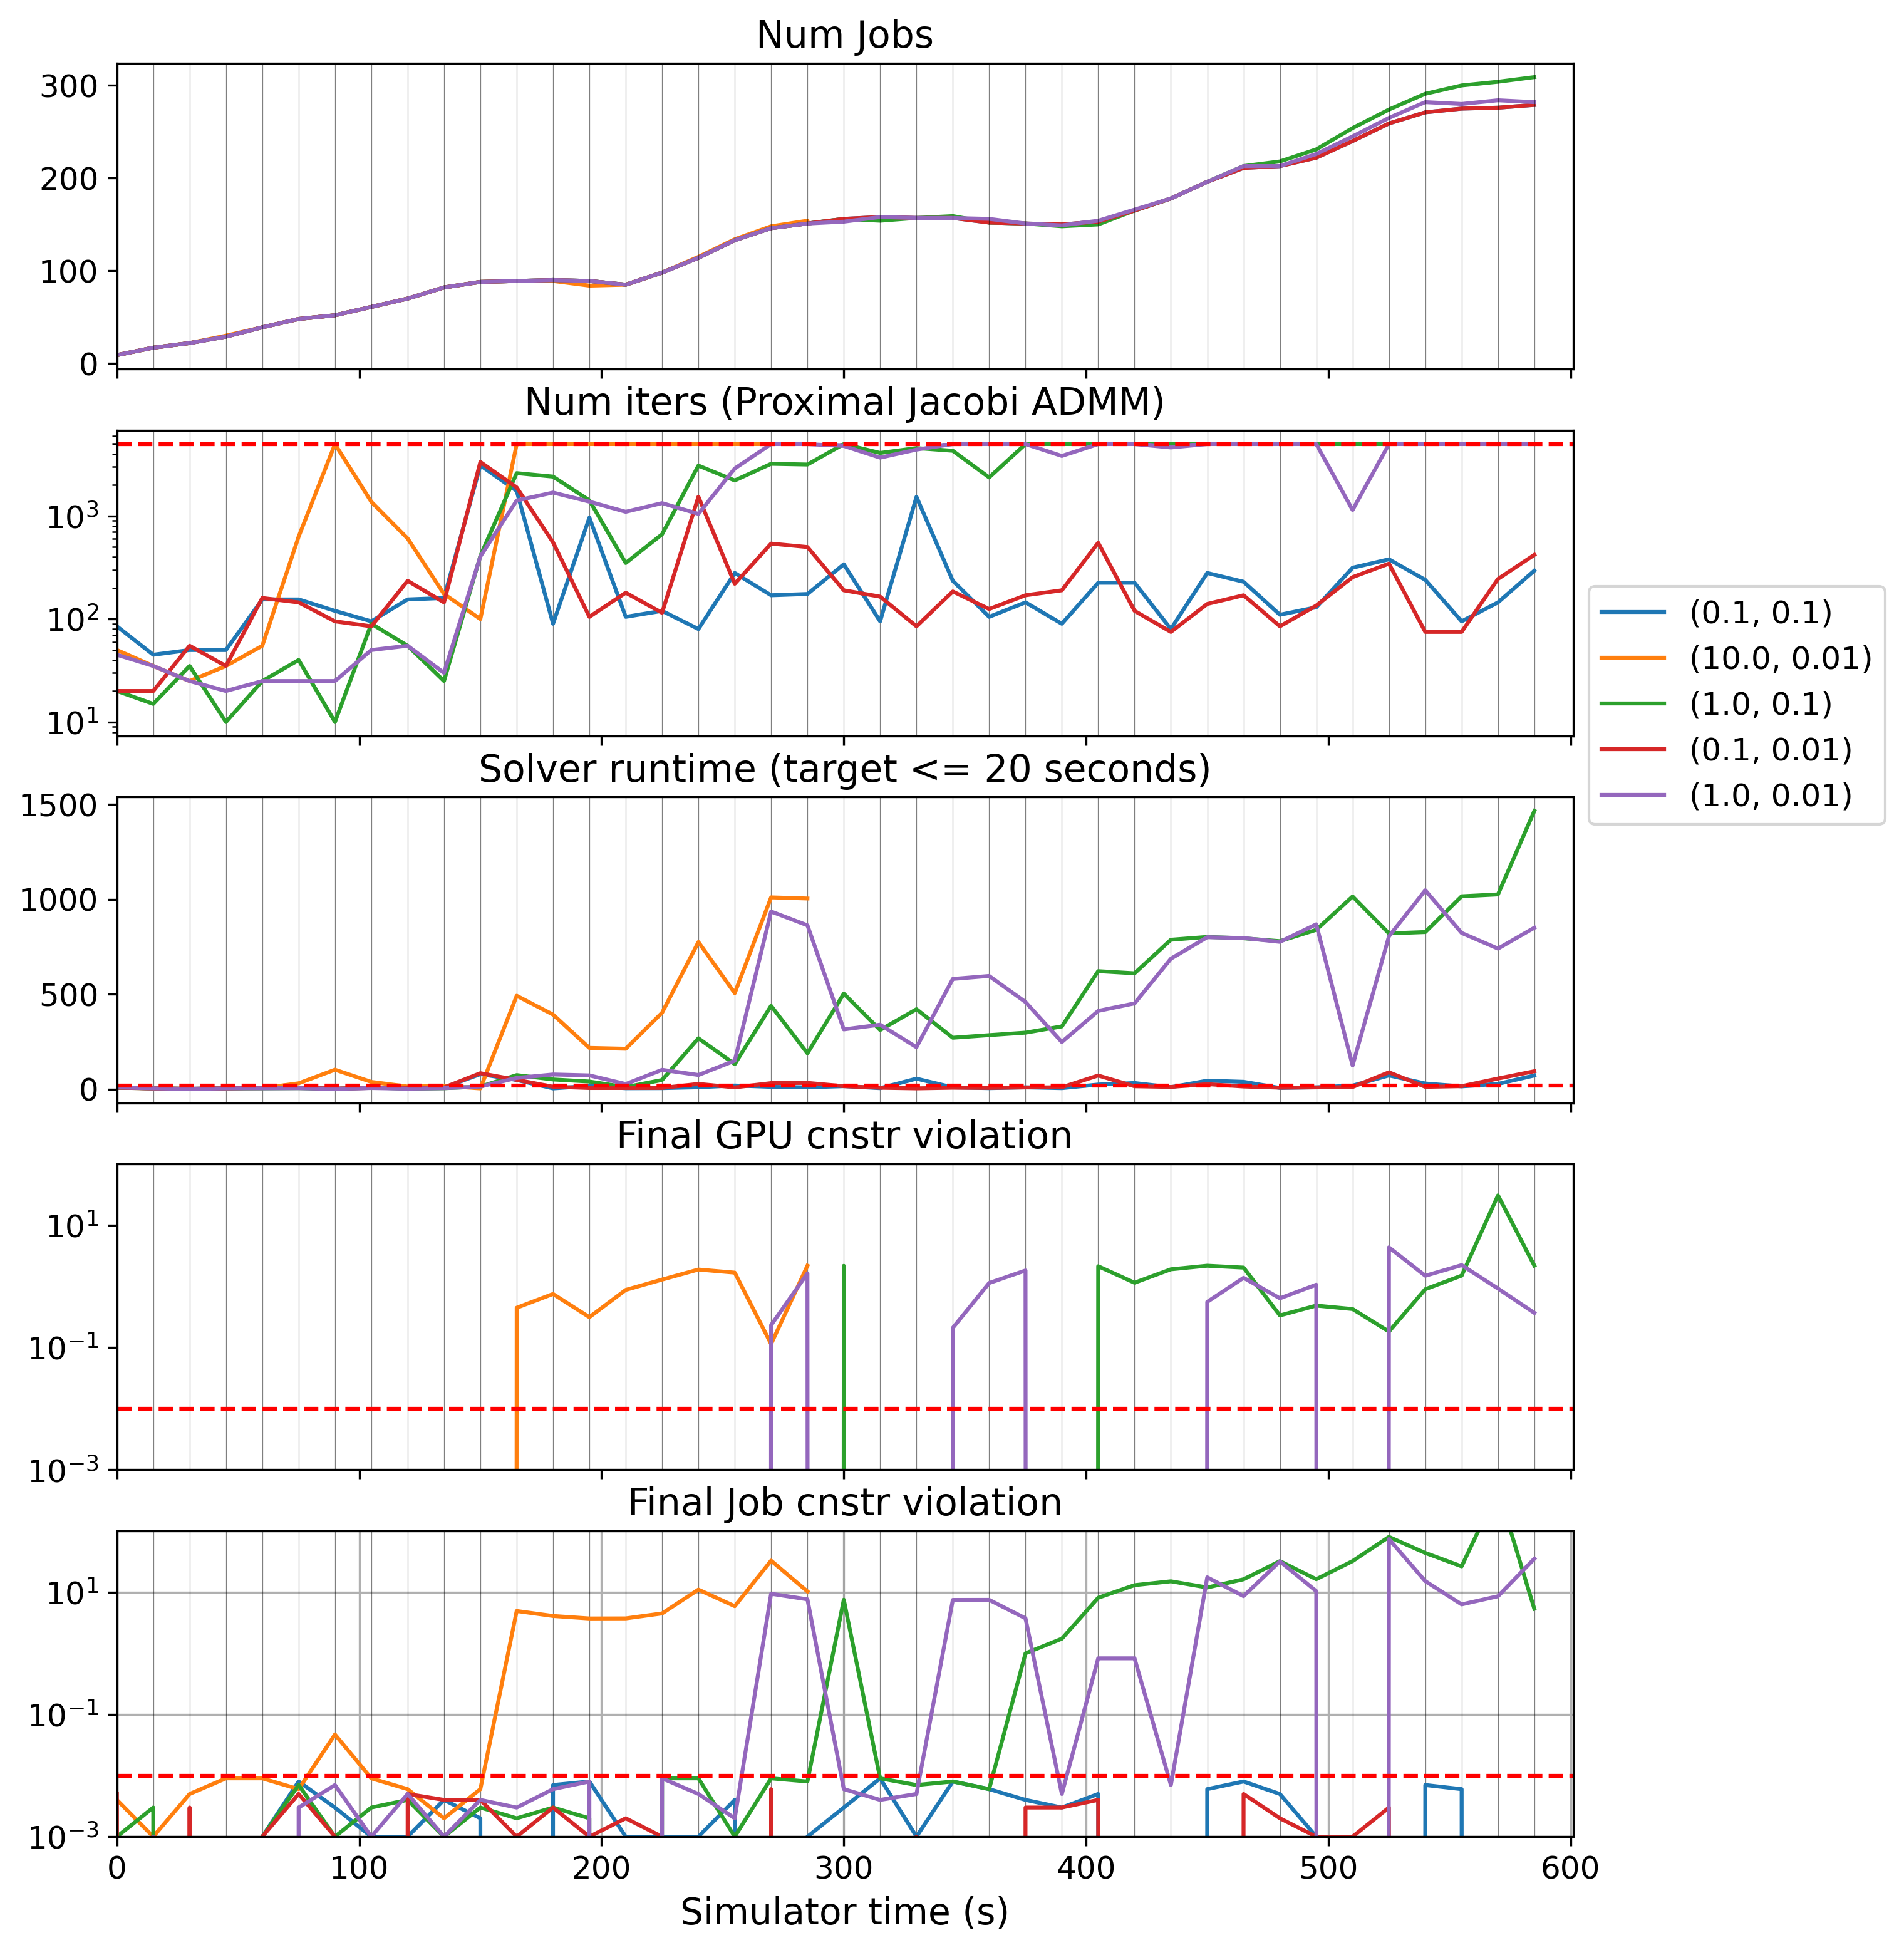

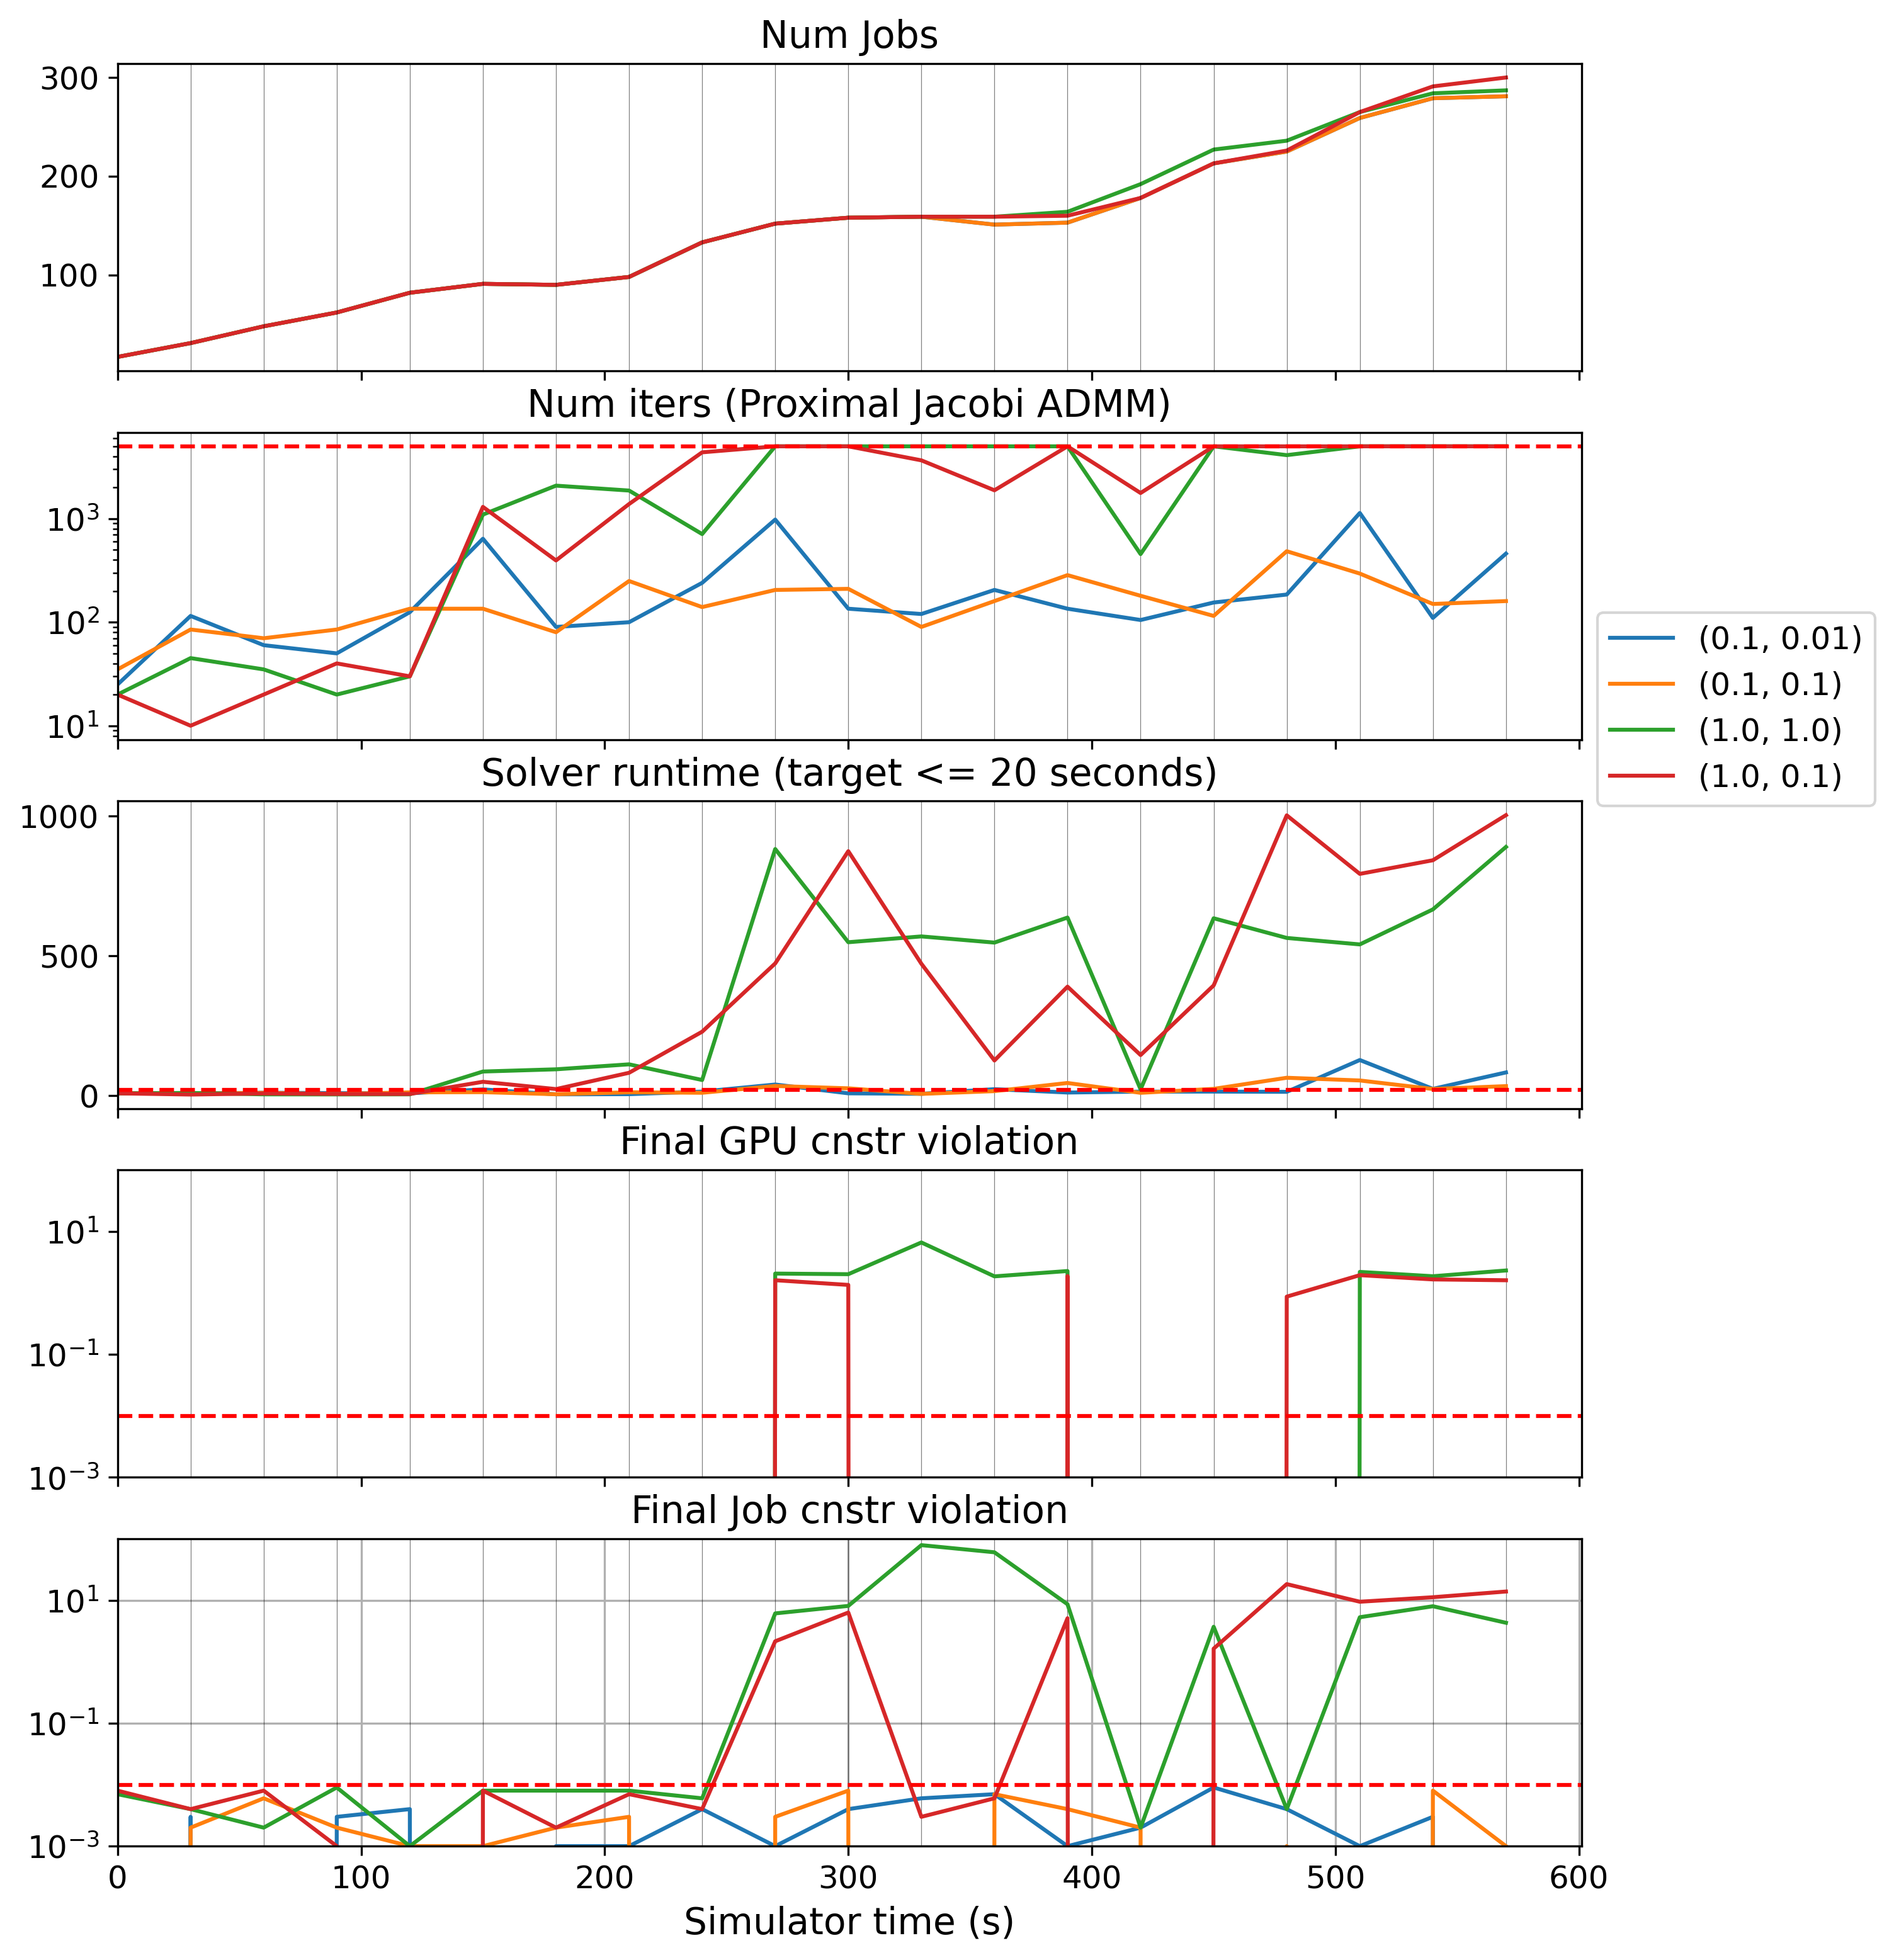

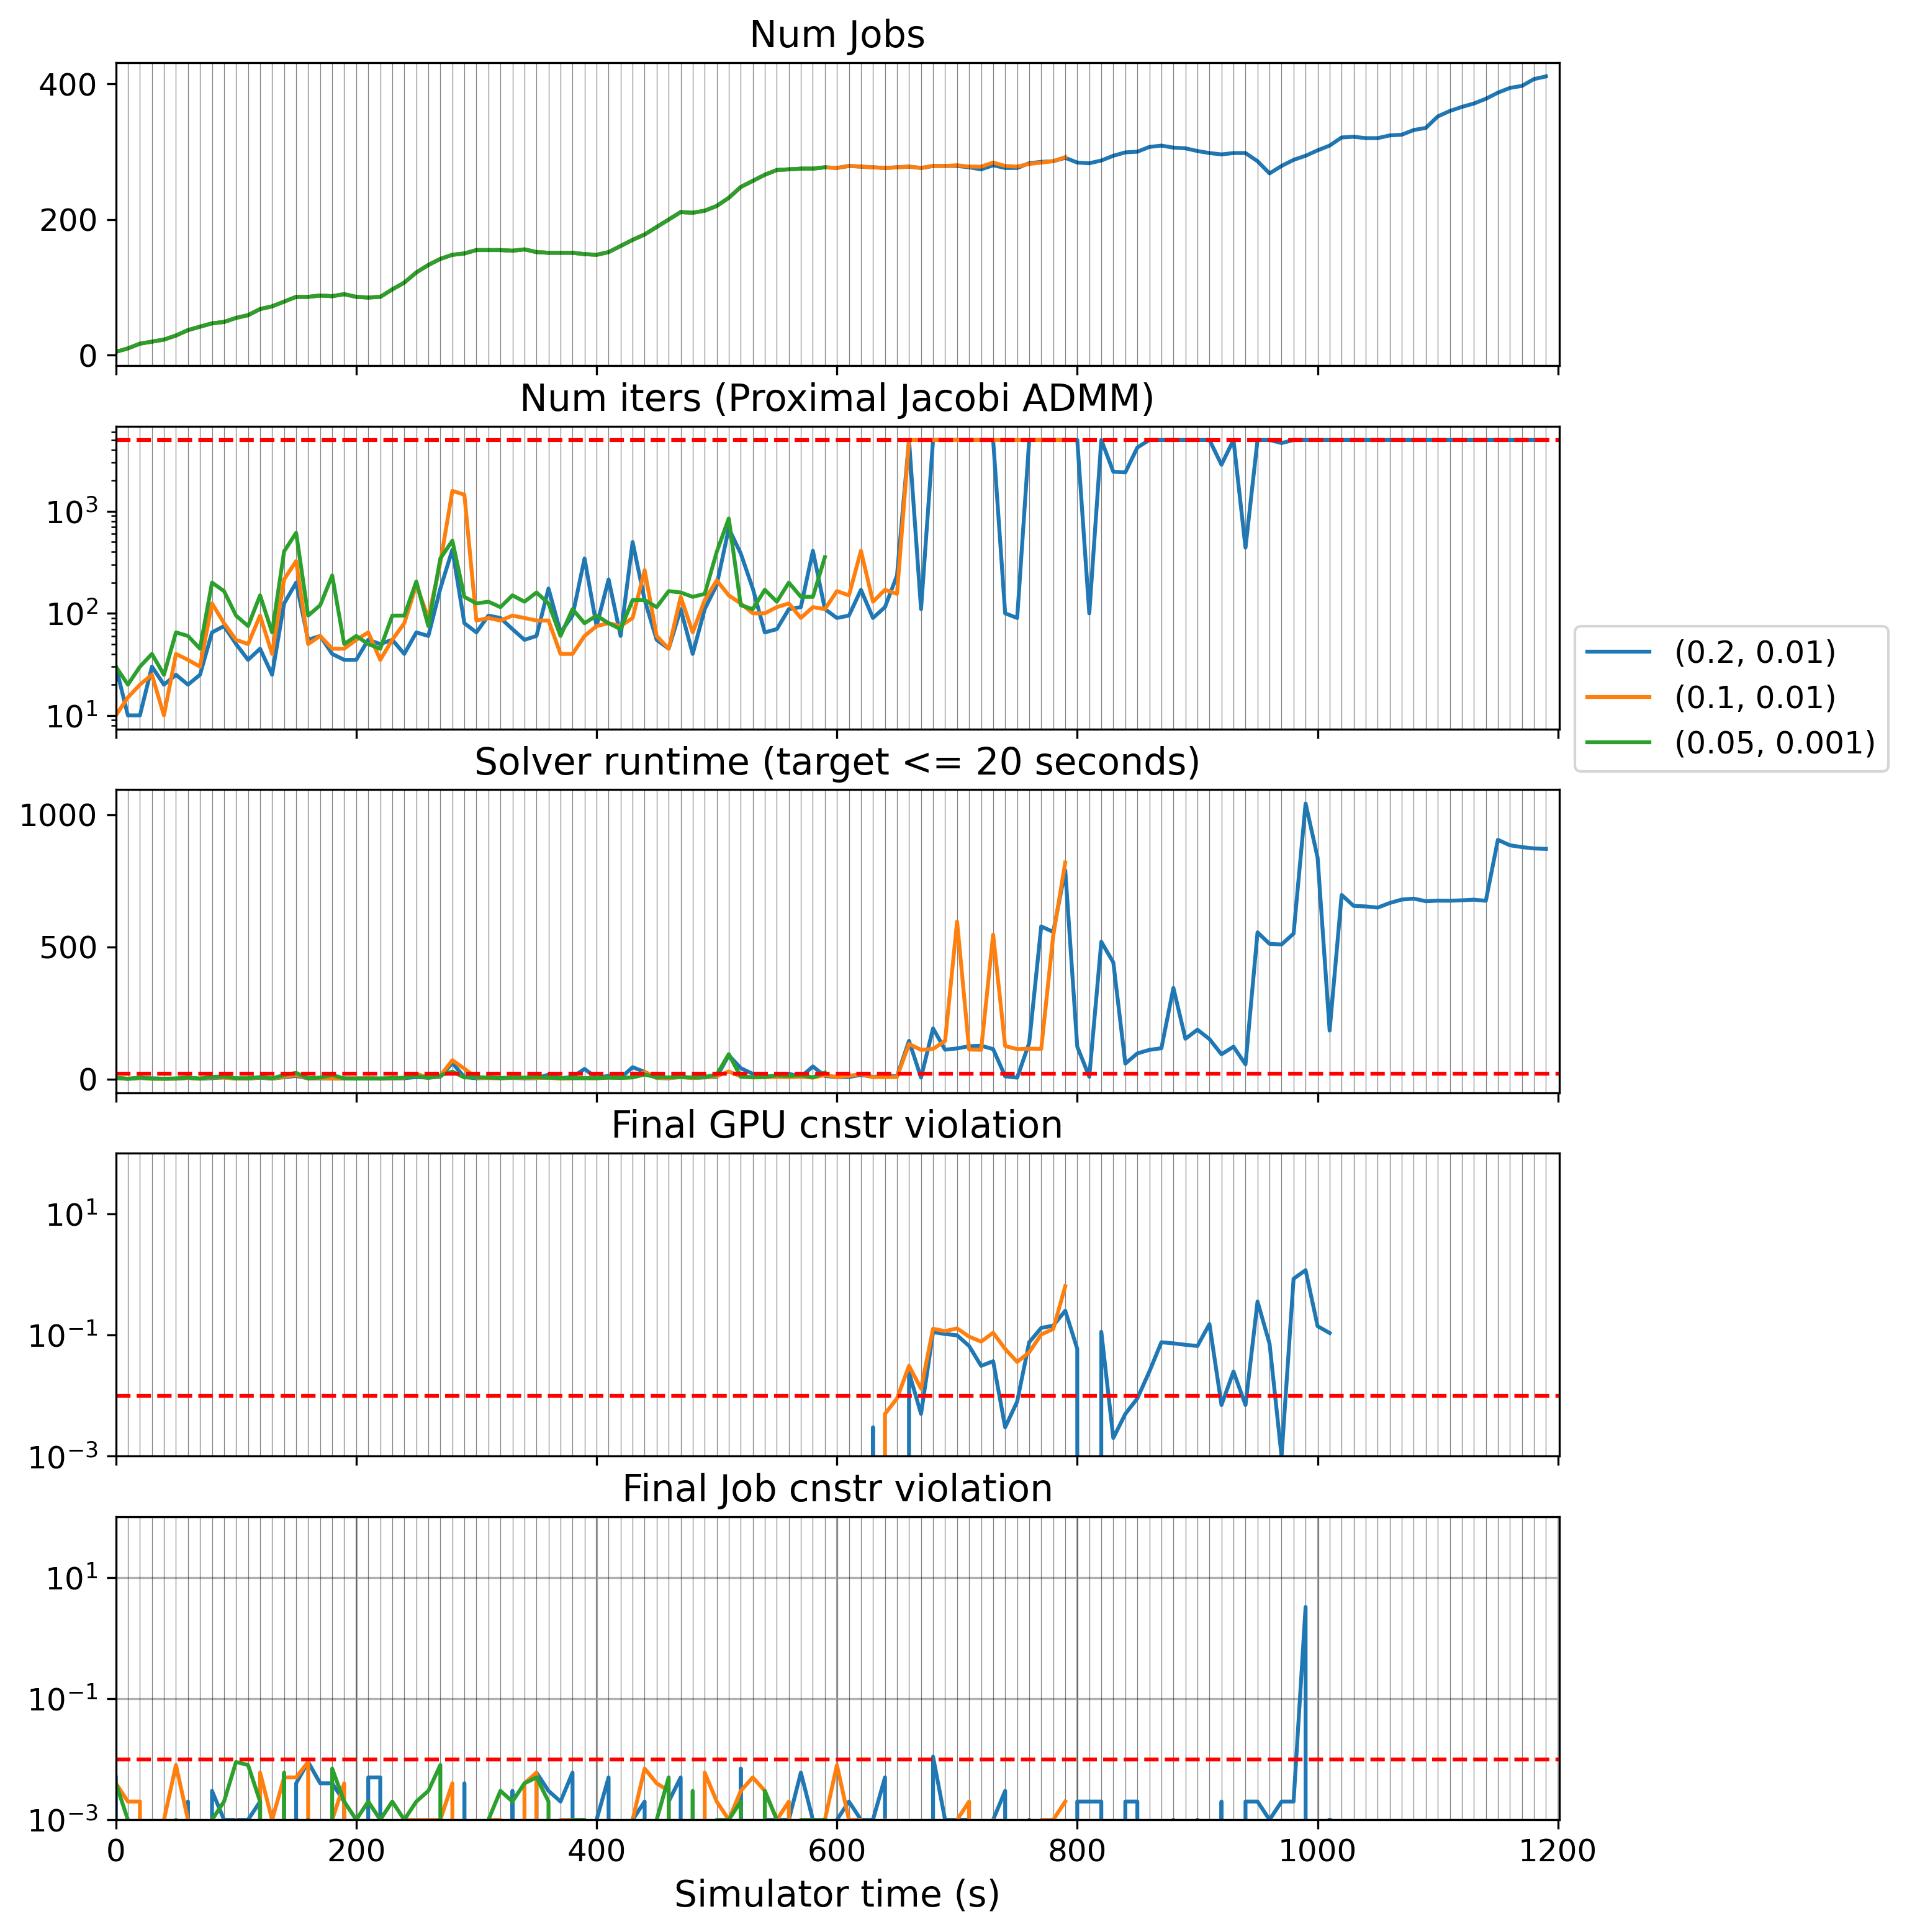

In [123]:
plot_warm_start_progress(data_10s, 10, "8x")
plot_warm_start_progress(data_15s, 15, "8x")
plot_warm_start_progress(data_30s, 30, "8x")
plot_warm_start_progress(data_16x_10s, 10, "16x")

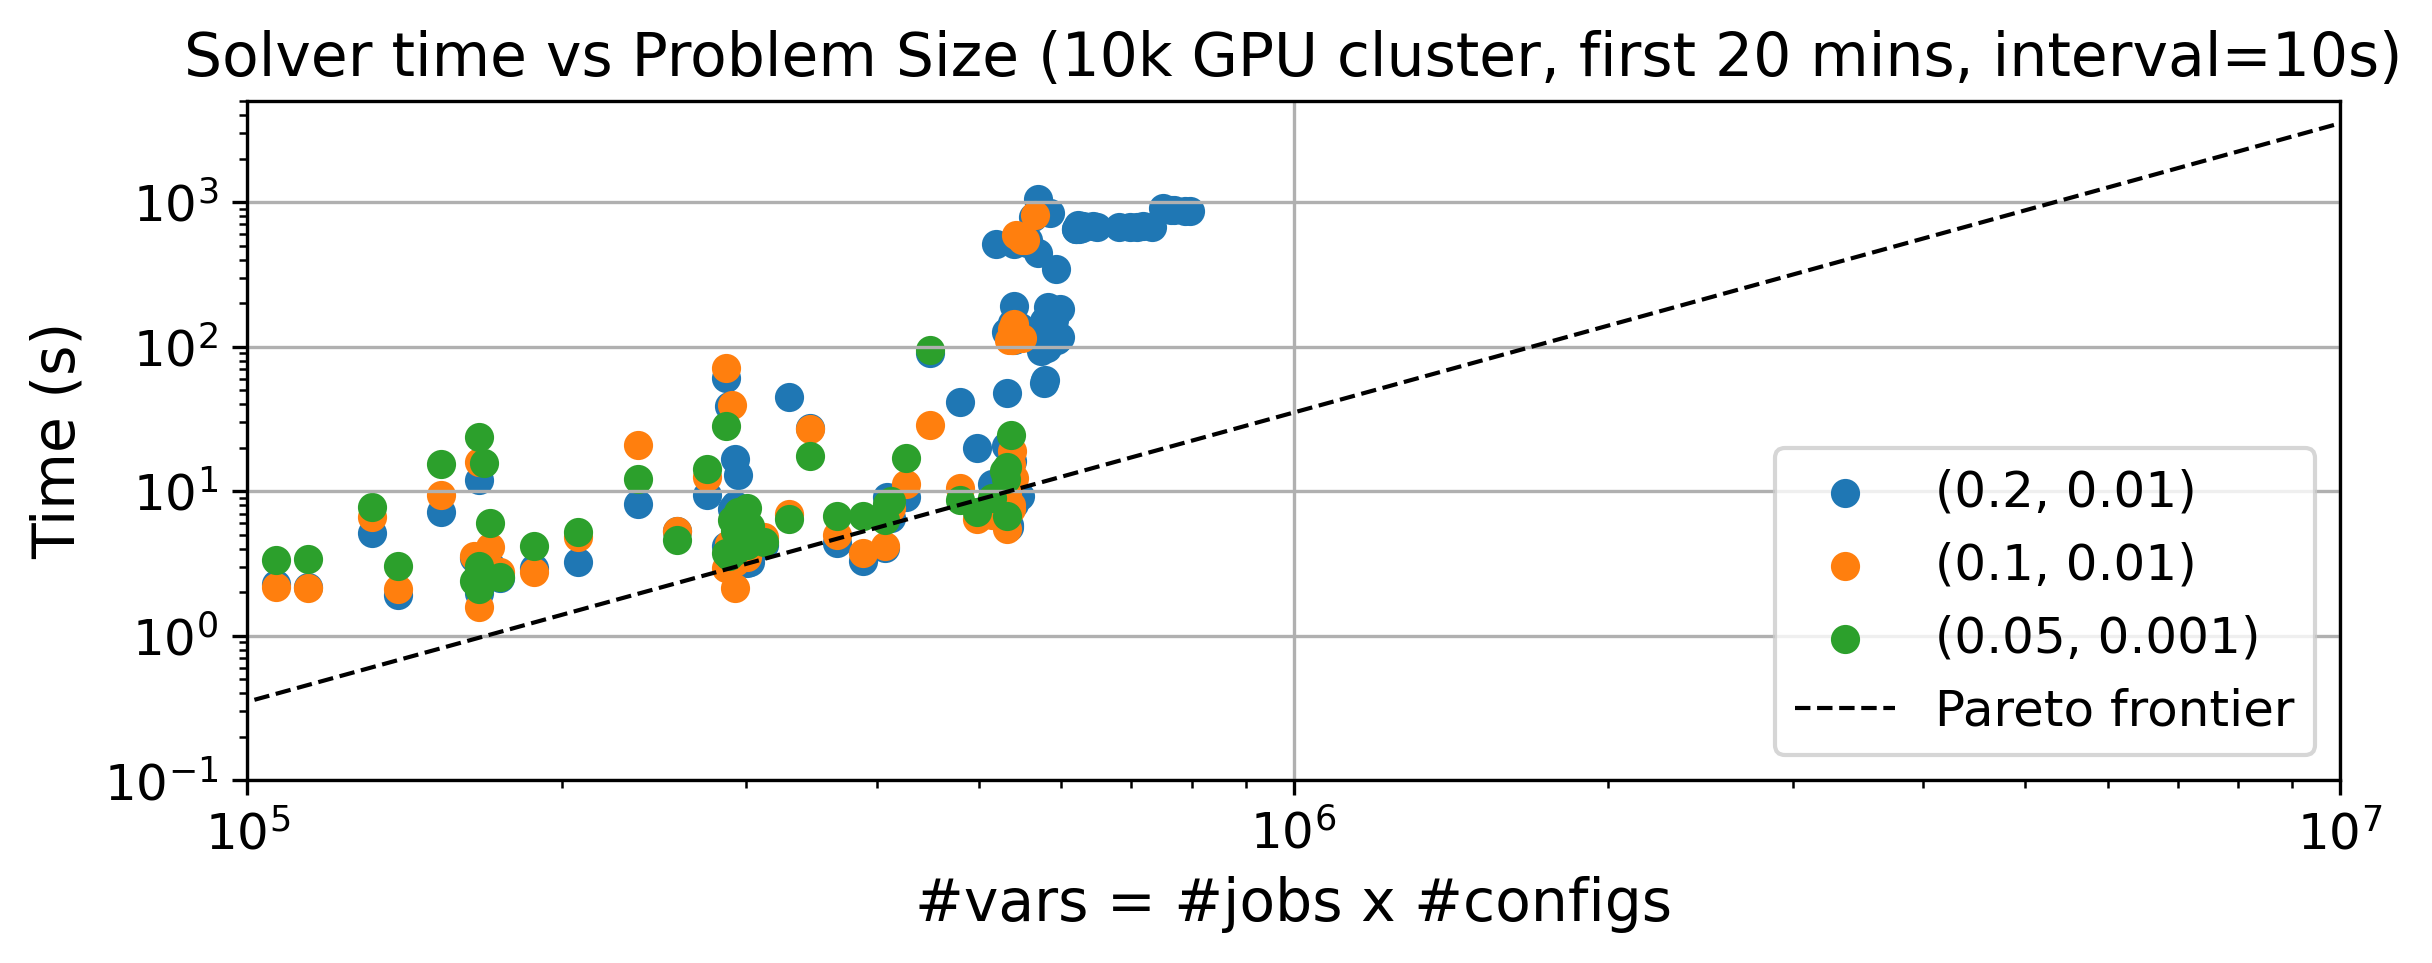

In [124]:
# plot runtime vs problem size for different beta, mu pairs
def plot_runtime_vs_problem_size(vals, interval, prefix_str):
  plt.gcf().clear()
  # get runtimes and problem sizes
  runtimes, problem_sizes = {}, {}
  for k, val in vals.items():
    runtimes[k] = []
    problem_sizes[k] = []
    for v in val:
      runtimes[k].append(v['solve_time_ms'] / 1000)
      problem_sizes[k].append(v['num_jobs'] * v['num_configs'])
  # plot runtime vs problem sizes for each beta, mu pair
  num_vals = len(list(runtimes.values())[0])
  for k, v in runtimes.items():
    plt.scatter(problem_sizes[k], v, label=f"{k}")
  # plot a line: y = mx + c, m=0.01, c=70
  x = np.linspace(1e4, 1e7, 20)
  y = 0.35*((x/1e5)**2)
  plt.plot(x, y, 'k--', linewidth=1, label="Pareto frontier")
  plt.yscale("log")
  plt.xscale("log")
  standardize(size=(9, 3))
  plt.xlim([1e5, 1e7])
  plt.ylim([0.1, 5000])
  plt.xlabel("#vars = #jobs x #configs", fontsize=14)
  plt.ylabel("Time (s)", fontsize=14)
  plt.legend()
  plt.title(f"Solver time vs Problem Size (10k GPU cluster, first {int(num_vals*interval / 60)} mins, interval={interval}s)")
  plt.savefig(f"/tmp/{prefix_str}_runtime_vs_problem_size_{interval}s.png", bbox_inches='tight', dpi=300)

plot_runtime_vs_problem_size(data_10s, 10, "8x")
plot_runtime_vs_problem_size(data_15s, 15, "8x")
plot_runtime_vs_problem_size(data_30s, 30, "8x")
plot_runtime_vs_problem_size(data_16x_10s, 10, "16x")